In [1]:
import importlib
import local_utils; importlib.reload(local_utils)
from local_utils import *

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 50.0% of memory, cuDNN 5110)


Import time: 12.321996927261353
Import time: 0.00017595291137695312


In [2]:
global_start = time()

In [3]:
train_df = pd.read_csv(DATA_DIR + '/train_v2.csv')
test_df = pd.read_csv(DATA_DIR + '/sample_submission_v2.csv')

label_map, inv_label_map, Y = process_labels(train_df)
print("Shape of Y {}".format(Y.shape))

train_inx, valid_inx = stratified_sampling(Y=Y, random_state=1000)
print("Train {}; Valid {};".format(len(train_inx), len(valid_inx)))

w_size = 128
h_size = 128
input_shape = (w_size, h_size, 3)
print(input_shape)

Shape of Y (40479, 17)
Train 36431; Valid 4048;
(128, 128, 3)


In [4]:
start = time()
X = load_images(train_df['image_name'].values, DATA_DIR + '/train/jpg', True, w_size, h_size)
print(X.shape)
print(time() - start)

(40479, 128, 128, 3)
325.311439037323


In [7]:
save_array(DATA_DIR + "/train_image_" + str("128")+'.dat', X)

In [5]:
model_name = "main_model"
batch_size = 96

In [6]:
class F2History(Callback):
    def on_train_begin(self, logs={}):
        self.f2_scores = []
    def on_epoch_end(self, epoch, logs ={}):
        p_valid = self.model.predict(self.validation_data[0])
        y_val = self.validation_data[1]
        f2 = fbeta_score(y_val, np.array(p_valid) >= 0.2, beta=2, average='samples')
        self.f2_scores.append(f2)
        return

f2_history = F2History()

In [7]:
model_checkpoint = ModelCheckpoint(
                DATA_DIR + '/models/' + model_name + '.h5', 
                monitor='val_loss', 
                verbose=1, 
                save_best_only=True, 
                save_weights_only=False, 
                mode='min',
                period=1)

In [8]:
p = 0.5
model_layers = [
    BatchNormalization(input_shape=input_shape),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),
    
    BatchNormalization(),
#     Dropout(p/2),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),

    BatchNormalization(),
#     Dropout(p/2),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),

    BatchNormalization(),
#     Dropout(p/2),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=2),

    BatchNormalization(),
#     Dropout(p/2),
    Conv2D(17, (3, 3), padding='same'),
#     Dropout(p),
    GlobalMaxPooling2D(),
    Activation('sigmoid')
    
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.25),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.25),
#     Dense(17, activation='sigmoid')
]
model = Sequential(model_layers)

In [9]:
# model = load_model(DATA_DIR + '/models/' + model_name + '1.h5', compile=False)

In [10]:
opt = optimizers.Adam(lr=1e-3, decay=75e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
__________

In [11]:
model.fit(X[train_inx], Y[train_inx],
          batch_size=batch_size,
          epochs=20,
          verbose=1,
          validation_data=(X[valid_inx], Y[valid_inx]),
          callbacks=[f2_history, model_checkpoint])

Train on 36431 samples, validate on 4048 samples
Epoch 1/20
36431/36431 [==============================] - 167s - loss: 0.2871 - acc: 0.8829 - val_loss: 0.1935 - val_acc: 0.9256
Epoch 2/20
36431/36431 [==============================] - 164s - loss: 0.1538 - acc: 0.9395 - val_loss: 0.1490 - val_acc: 0.9410

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)



Epoch 3/20
36431/36431 [==============================] - 164s - loss: 0.1359 - acc: 0.9467 - val_loss: 0.1318 - val_acc: 0.9470
Epoch 4/20
36431/36431 [==============================] - 164s - loss: 0.1248 - acc: 0.9512 - val_loss: 0.1231 - val_acc: 0.9523
Epoch 5/20
36431/36431 [==============================] - 164s - loss: 0.1172 - acc: 0.9542 - val_loss: 0.1218 - val_acc: 0.9517
Epoch 6/20
36431/36431 [==============================] - 164s - loss: 0.1116 - acc: 0.9564 - val_loss: 0.1279 - val_acc: 0.9479
Epoch 7/20
36431/36431 [==============================] - 164s - loss: 0.1075 - acc: 0.9581 - val_loss: 0.1078 - val_acc: 0.9578
Epoch 8/20
36431/36431 [==============================] - 164s - loss: 0.1034 - acc: 0.9597 - val_loss: 0.1088 - val_acc: 0.9576
Epoch 9/20
36431/36431 [==============================] - 165s - loss: 0.0993 - acc: 0.9615 - val_loss: 0.1056 - val_acc: 0.9593
Epoch 10/20
36431/36431 [==============================] - 164s - loss: 0.0958 - acc: 0.9627 - v

Max F2 Score 0.9139926925579585; Epoch 15;


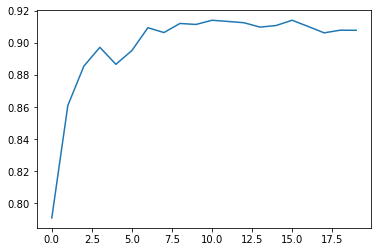

In [18]:
print("Max F2 Score {}; Epoch {};".format(max(f2_history.f2_scores),np.argmax(f2_history.f2_scores)))
plt.plot(f2_history.f2_scores)
plt.show()

In [13]:
stop

NameError: name 'stop' is not defined

In [25]:
# model.save(DATA_DIR + '/models/' + model_name + '.h5')

In [36]:
model = load_model(DATA_DIR + '/models/' + model_name + '.h5', compile=False)
opt = optimizers.Adam(lr=1e-3, decay=75e-5)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model.evaluate(X[valid_inx], Y[valid_inx], batch_size=batch_size, verbose=1)

4032/4048 [============================>.] - ETA: 0s

[0.1034902488525677, 0.96022729722878675]

In [37]:
p_X = model.predict(X, batch_size=batch_size, verbose=1)

40479/40479 [==============================] - 57s    


In [38]:
start = time()
thres = find_best_thresholds(Y[valid_inx], p_X[valid_inx])
save_array(DATA_DIR + '/models/' + model_name + '_thres.dat', thres)
print(time() - start)

/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


5: Score 0.9146585253931239 with 0.0905
4: Score 0.9141957836996095 with 0.036000000000000004
3: Score 0.9142178226932598 with 0.0555
6: Score 0.9143275309837556 with 0.1475
0: Score 0.9140700463261754 with 0.195
2: Score 0.9142790606776148 with 0.1015
7: Score 0.9141206606018107 with 0.0655
1: Score 0.9140298457960663 with 0.2895


/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


8: Score 0.9141847782759426 with 0.1135
14: Score 0.9140347023088436 with 0.518
10: Score 0.9143496383953952 with 0.15
11: Score 0.9151386115873057 with 0.10200000000000001
13: Score 0.9140450443429003 with 0.1875
12: Score 0.9145534571382067 with 0.136
9: Score 0.9141308814091661 with 0.1495
15: Score 0.9139778827331259 with 0.1835
16: Score 0.9143637260007706 with 0.183
29.310418128967285


In [ ]:
print(f2_score(Y, p_X, thres))
print(f2_score(Y[train_inx], p_X[train_inx], thres))
print(f2_score(Y[valid_inx], p_X[valid_inx], thres))

0.925857175729
0.926629247864
0.918908717244


In [ ]:
del X
del p_X

model = load_model(DATA_DIR + '/models/' + model_name + '.h5', compile=False)
thres = load_array(DATA_DIR + '/models/' + model_name + '_thres.dat')

start = time()
X_test = load_images(test_df['image_name'].values, DATA_DIR + '/test-jpg', True, w_size, h_size)
print(X_test.shape)
print(time() - start)

Process ForkPoolWorker-35:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.5/multiprocessing/pool.py", line 125, in worker
    put((job, i, result))
  File "/opt/conda/lib/python3.5/site-packages/joblib/pool.py", line 386, in put
    return send(obj)
  File "/opt/conda/lib/python3.5/site-packages/joblib/pool.py", line 372, in send
    self._writer.send_bytes(buffer.getvalue())
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/opt/conda/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
KeyboardInterru

In [ ]:
p_X_test = model.predict(X_test, batch_size=batch_size, verbose=1)

In [ ]:
start = time()
for inx in np.arange(len(test_df)):
    test_df['tags'][inx] = ' '.join([inv_label_map[i] for i, b in enumerate(p_X_test[inx] >= thres) if b])
print(time() - start)

test_df.head()

In [ ]:
test_df.to_csv(DATA_DIR + '/results/' + model_name + '_submission.csv', index=False)
FileLink('data/results/' + model_name + '_submission.csv')

In [ ]:
print((time() - global_start)/60)

### Pretrain weights

In [8]:
model = load_model(DATA_DIR + '/models/' + model_name + '.h5', compile=False)

model.layers.pop()
model.layers.pop()
model.layers.pop()
model.layers.pop()
model = Sequential(model.layers) # reinitialize
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        36928     
__________

In [9]:
main_train_feat = model.predict(X, batch_size=batch_size, verbose = 1)
save_array(DATA_DIR + '/models/main_train_feat.dat', main_train_feat)

40479/40479 [==============================] - 57s    


In [10]:
del X
del main_train_feat

start = time()
X_test = load_images(test_df['image_name'].values, DATA_DIR + '/test-jpg', True, w_size, h_size)
print(X_test.shape)
print(time() - start)

(61191, 128, 128, 3)
24.137157917022705


In [11]:
main_test_feat = model.predict(X_test, batch_size=batch_size, verbose = 1)
save_array(DATA_DIR + '/models/main_test_feat.dat', main_test_feat)

61191/61191 [==============================] - 85s    


In [ ]:
# main_train_feat = load_array(DATA_DIR + '/models/main_train_feat.dat')
# print(main_train_feat.shape)

# main_test_feat = load_array(DATA_DIR + '/models/main_test_feat.dat')
# print(main_test_feat.shape)